In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

In [2]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream

2024-05-06 11:00:40.651611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:00:40.651663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:00:40.653131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 11:00:40.662875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 11:00:42.408668: W tensorflow/comp

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
from akita_utils.dna_utils import dna_1hot, hot1_rc

from akita_utils.utils import split_df_equally

from akita_utils.h5_utils import (
    initialize_stat_output_h5,
    initialize_maps_output_h5,
    initialize_maps_output_references,
    write_stat_metrics_to_h5,
    write_maps_to_h5,
)

In [6]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
out_dir = "./OUT"
stats = "SCD"
# stats = "SCD"
batch_size=8 
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [7]:
CTCT_table = "./top10_boundary.tsv"
# CTCT_table = "./top10_dot.tsv"

In [8]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [9]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"

In [10]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"

In [11]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json'

In [12]:
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [13]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5'

In [14]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [15]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [16]:
seq_length

1310720

In [17]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [18]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

In [19]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

num_insert_backgrounds = seq_coords_df["background_index"].max()

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [ ]:
# initialize output
# stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

In [20]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 12s 2s/step


In [21]:
from akita_utils.seq_gens import symmertic_insertion_seqs_gen

In [22]:
seq_coords_df = seq_coords_df.sample(n=10)

In [23]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [24]:
num_experiments = len(seq_coords_df)

In [25]:
stats

['SCD']

In [26]:
from akita_utils.stats_utils import plot_map

In [27]:
from akita_utils.utils import ut_dense

In [28]:
from akita_utils.stats_utils import calculate_SCD

In [29]:
vmin=-0.6
vmax=0.6
width=5
height=5
palette="RdBu_r"

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

experiment 0
2/2 [==============================] - 12s 2s/step
alt


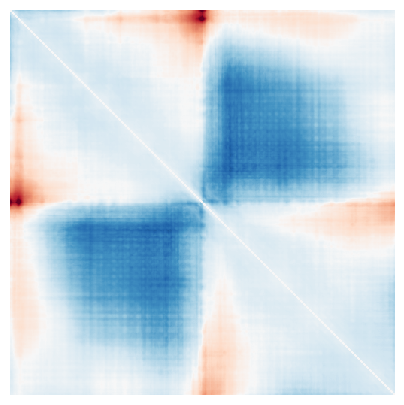

experiment 1
alt


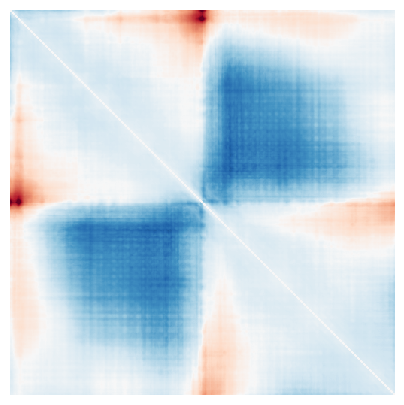

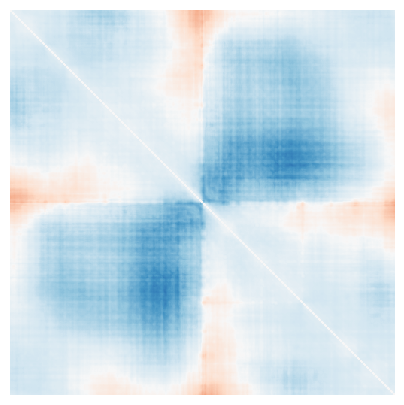

experiment 2
alt


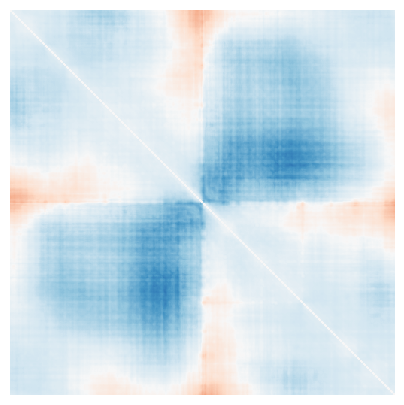

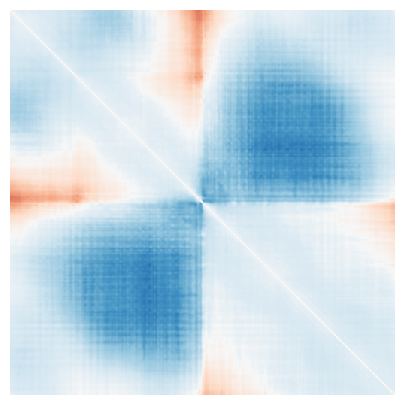

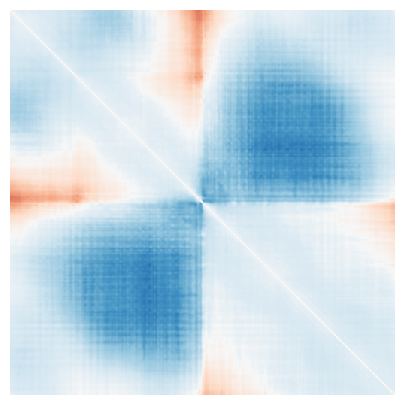

In [31]:
# for exp_index in range(num_experiments):
for exp_index in range(3):
    
    print(f"experiment {exp_index}")

    # bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    # reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    # ref_maps_t0 = ut_dense(reference_prediction_matrix)
    alt_maps_t0 = ut_dense(prediction_matrix)

    # print("ref")
    # plot_map(ref_maps_t0[:,:,0])
    print("alt")
    plot_map(alt_maps_t0[:,:,0])
    # print("alt-ref")
    # plot_map(alt_maps_t0[:,:,0] - ref_maps_t0[:,:,0])

    fig = plt.figure(figsize=(width, height))
    
    sns.heatmap(
        alt_maps_t0[:,:,0],
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.savefig(f"./boundary_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    # plt.savefig(f"./dot_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    # plt.show()
    
    # print("SCD, ref")
    # print(calculate_SCD(ref_maps_t0))
    # print("SCD, alt")
    # print(calculate_SCD(alt_maps_t0))
    # print("SCD, alt with ref")
    # print(calculate_SCD(alt_maps_t0, ref_maps_t0))    
    
    # write_stat_metrics_to_h5(prediction_matrix,
    #                             reference_prediction_matrix,
    #                             stats_out,
    #                             exp_index,
    #                             head_index,
    #                             model_index,
    #                              diagonal_offset=2,
    #                             stat_metrics=stats)   

In [33]:
# for key in stats_out:
#     print(key)

In [35]:
# stats_out["SCD_h1_m1"][:]

In [36]:
# stats_out["ref_INS-16_h1_m1"][:]

In [37]:
# stats_out["alt_INS-16_h1_m1"][:]

In [38]:
genome_open.close()
# stats_out.close()